# Using AI based diffusive size factors for extracted networks

This notebook illustrates the use of the deep learning based diffusive conductance algorithm decribed [here](https://doi.org/10.1016/j.cageo.2022.105086). PoreSpy's `AI_size_factor` includes the steps for predicting the diffusive size factors of the conduit images. Note that the diffusive conductance of the conduits can be then calculated by multiplying the size factor by diffusivity of the phase. The function takes in the images of segmented porous medium and returns an array of diffusive size factors for all conduits in the image. Therefore, the framework can be applied to both one conduit image as well as a segmented image of porous medium:

<img src="https://user-images.githubusercontent.com/43128873/116145783-bd458380-a6ab-11eb-8103-fb9a93f0599c.png" alt="PS_dl" width="500"/>

# Trained model and supplementary materials
To use the `AI_diffusive_size_factor`, the trained model, and training data distribution are required. The AI model files and additional files used in this example are available [here](https://dl.dropboxusercontent.com/s/jrq82twl0vwedy4/AI_example_data.rar?dl=0). The folder contains following files:

- Trained model weights: This file includes only weights of the deep learning layers. To use this file, the Resnet50 model structure must be built first.

- Trained data distribution: This file will be used in denormalizing predicted values based on normalized transform applied on training data. The denormalizing step is included in `AI_diffusive_size_factor` method.

- Finite difference diffusive conductance: This file is used in this example to compare the prediction results with finite difference method for segmented regions

- Pair of regions: This file is used in this example to compare the prediction results with finite difference method for a pair of regions

Note that to use `AI_diffusive_size_factor`, [Scikit-learn](https://scikit-learn.org/stable/index.html?msclkid=9e175644bb2511ecb89dded5ce21b89f) and [Tensorflow](https://www.tensorflow.org/?msclkid=a5a214bdbb2511ecadd52383bd2650c1) must be installed. Import necessary packages and the AI model: 

In [1]:
import porespy as ps
import openpnm as op
import scipy as sp
import numpy as np
import h5py
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
import os
import warnings
warnings.filterwarnings("ignore")
path = os.getcwd()+'/AI_example_data/'
path_train= path+'g_train_original.hdf5'
path_weight = path+'model_weights.h5'
g_train = h5py.File(path_train, 'r')['g_train'][()]
model = ps.networks.create_model()
model.load_weights(path_weight)

2022-04-12 14:11:44.930601: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-12 14:11:46.421616: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 47226 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:17:00.0, compute capability: 7.5
2022-04-12 14:11:46.423937: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 47010 MB memory:  -> device: 1, name: Quadro RTX 8000, pci bus id: 0000:65:00.0, compute capability: 7.5


## Create test image

We can create a 3D image using PoreSpy's `poly_disperese_spheres` generator:

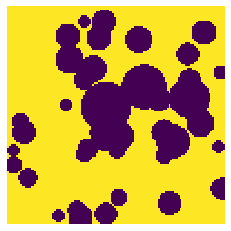

In [2]:
np.random.seed(17)
shape = [120, 120, 120]
dist = sp.stats.norm(loc=7, scale=5)
im = ps.generators.polydisperse_spheres(shape=shape,
                                        porosity=0.7,
                                        dist=dist,
                                        r_min=7)
fig, ax = plt.subplots(1, 1, figsize=[4, 4])
ax.imshow(im[:,:,20], origin='lower', interpolation='none')
ax.axis(False);

## Extract the network

We then extract the pore network of the porous medium image using PoreSpy's `snow2 ` algorithm. `snow2` returns the segmented image of the porous medium as well as extracted network data.

In [3]:
snow = ps.networks.snow2(im, boundary_width=0, parallelization = None)
regions = snow.regions
net = snow.network

0it [00:00, ?it/s]

Extracting pore and throat properties:   0%|          | 0/199 [00:00<?, ?it/s]

## Apply AI_diffusive_size_factor

AI_based diffusive size factors of conduits in the extracted network can then be calculated applying `AI_diffusive_size_factor` on the segmented regions. We can then define `throat.AI_diffusive_size_factor` property and assign the predicted size_factor to this property.

In [4]:
conns = net['throat.conns']
size_factors = ps.networks.AI_diffusive_size_factor(regions, model= model, g_train=g_train, throat_conns=conns)
net['throat.AI_diffusive_size_factor']= size_factors

Preparing images tensor:   0%|          | 0/744 [00:00<?, ?it/s]

2022-04-12 14:12:28.789302: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8303
2022-04-12 14:12:29.787334: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


The resulting network can then be imported to OpenPNM for later use such as diffusive mass transport simulations problems. Let's visualize the network:

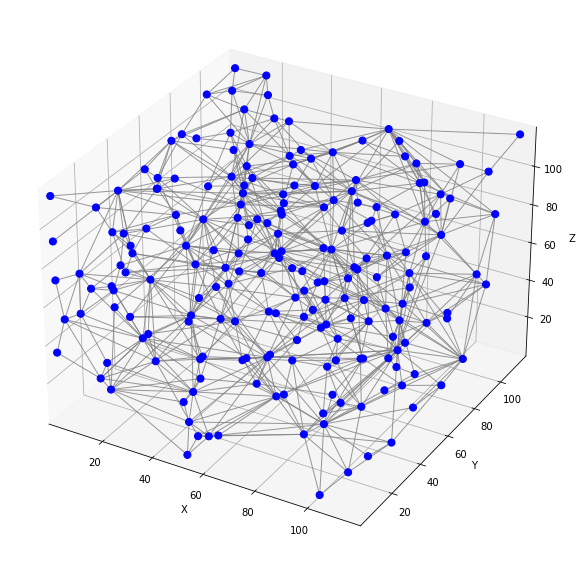

In [6]:
pn , geo = op.io.PoreSpy.import_data(net)
fig, ax = plt.subplots(1, 1, figsize=[8, 8])
ax = op.topotools.plot_connections(network=pn, alpha=0.8, color='grey', ax=ax)
ax = op.topotools.plot_coordinates(network=pn, ax=ax, color='b', markersize=50)

## Compare with finite difference method

Now that the extracted network includes AI_based diffusive size factor data, we can use the network to compare the accuracy of `AI_diffusive_size_factor`, shape factor method,and geometry method (no shape factor) in contrast to finite difference method. Assuming a generic phase with diffusivity of 1, the diffusive conductance of the conduits will be equal to their diffusive size factors. The diffusive conductance of the conduits can be calculated using OpenPNM's generic_diffusive method. The diffusive conductance of the conduits using shape factor based method assuming cones and cylinders shapes for pores and throats can be calculated as follows:

In [7]:
geo.add_model(propname='throat.diffusive_size_factor',
              model = op.models.geometry.diffusive_size_factors.cones_and_cylinders)
phase=op.phases.GenericPhase(network=pn)
phys = op.physics.GenericPhysics(network=pn, phase=phase, geometry=geo)
phase['pore.diffusivity'] = 1
phase['throat.diffusivity'] = 1
phys.add_model(propname='throat.diffusive_conductance',
               model=op.models.physics.diffusive_conductance.generic_diffusive)
g_SF=phys['throat.diffusive_conductance']

To find the diffusive conductance of the conduit using geometry method (no shape factor) we assume cylindrical pores and throats:

In [8]:
cn=pn.conns
L1, Lt, L2 = geo['pore.diameter'][cn[:,0]]/2, geo['throat.length'], geo['pore.diameter'][cn[:,1]]/2
D1, Dt, D2 = geo['pore.diameter'][cn[:,0]], geo['throat.diameter'], geo['pore.diameter'][cn[:,1]]
A1, At, A2 = np.pi*D1**2/4, np.pi*Dt**2/4, np.pi*D2**2/4
g_Geo = 1/(L1/A1+L2/A2+Lt/At)

The diffusive conductance of the conduit using AI-based method:

In [9]:
phys.add_model(propname='throat.diffusive_conductance',
               model=op.models.physics.diffusive_conductance.generic_diffusive,
              size_factors='throat.AI_diffusive_size_factor')
g_AI=phys['throat.diffusive_conductance']

Now let's compare the diffusive conductance calculated from geometry-based method, shape factor based-method, and AI-based method with reference finite difference method. he reference diffusive conductance values for comparisons are calculated using finite difference method explained [here](https://doi.org/10.1016/j.cageo.2022.105086) and saved in the example data folder.

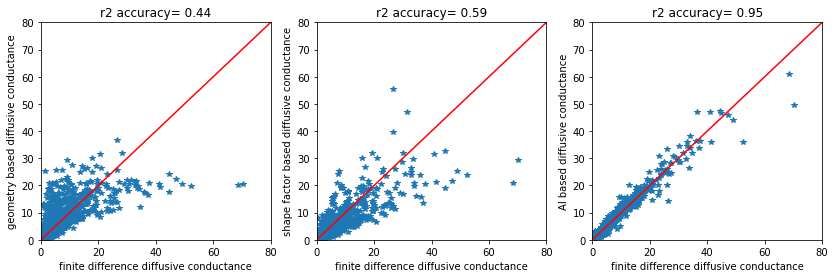

In [10]:
g_FD = h5py.File(path+'g_finite_difference120-phi7.hdf5', 'r') ['g_finite_difference'][()]
fig, ax = plt.subplots(1, 3, figsize=[14, 4])
ax[0].plot(g_FD,g_Geo,'*',[0,80],[0,80],'r')
ax[0].set_xlim([0,80])
ax[0].set_ylim([0,80])
ax[0].set_xlabel('finite difference diffusive conductance')
ax[0].set_ylabel('geometry based diffusive conductance')
ax[0].set_title('r2 accuracy= '+str(np.round(r2_score(g_FD, g_Geo),2)))
ax[1].plot(g_FD,g_SF,'*',[0,80],[0,80],'r')
ax[1].set_xlim([0,80])
ax[1].set_ylim([0,80])
ax[1].set_xlabel('finite difference diffusive conductance')
ax[1].set_ylabel('shape factor based diffusive conductance')
ax[1].set_title('r2 accuracy= '+str(np.round(r2_score(g_FD, g_SF),2)))
ax[2].plot(g_FD,g_AI,'*',[0,80],[0,80],'r')
ax[2].set_xlim([0,80])
ax[2].set_ylim([0,80])
ax[2].set_xlabel('finite difference diffusive conductance')
ax[2].set_ylabel('AI based diffusive conductance')
ax[2].set_title('r2 accuracy= '+str(np.round(r2_score(g_FD, g_AI),2)));

As shown in the scatter plots, the AI-based diffusive conductance method predicts the conductance values with a higher accuracy than geometry-based and shape factor-based methods. A comprehensive comparison between these methods for a large dataset can be found [here](https://doi.org/10.1016/j.cageo.2022.105086). 